### Build a Basic Chatbot with Langgraph(GRAPH API)

#### Build a basic chatbot

Component of Langgraph

1. Nodes : Each node represents an LLM agent or you can say basically nodes are the workflow steps where a input converted into some output using LLM
2. Edges: Edges are the communication channels between nodes.
3. State : State is something which will have all the input/output record of nodes which works as snapshot of current workflow 


In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [9]:
class State(TypedDict):
    """
    Messages have the type "list". The "add_messages" function.
    in the annotation defines how this state key should be updated
    (in this case, it appends messages to the list, rather than overwriting them.)
    We are using TypeDict because this class will return a type of dictionary
    """
    messages:Annotated[list, add_messages] # add the messages in the list with the help of add_messages where this add_messages is a reducer it will not replace messages in the list it will only append messages into it.

graph_builder = StateGraph(State)


In [10]:
graph_builder

In [11]:
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7430c1a82ba0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7430c18fa570>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
llm = init_chat_model("groq:llama3-8b-8192")
llm     

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7430c229f140>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7430c19b5d90>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
# Node functionality
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [15]:
graph_builder=StateGraph(State)
graph_builder.add_node("llmchatbot", chatbot)

In [16]:
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

In [17]:
# compile the graph
graph = graph_builder.compile()

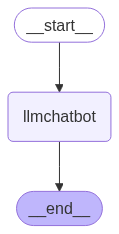

In [18]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
response = graph.invoke({"messages" : "Hi"})

In [20]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

# Chatbot with Tool

In [21]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is bajaj fans?")

{'query': 'What is bajaj fans?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Best Bajaj fan: Top 7 most trusted options with unmatched reliability ...',
   'url': 'https://www.hindustantimes.com/technology/best-bajaj-fan-top-7-most-trusted-options-with-unmatched-reliability-to-upgrade-your-living-space-101709885502998.html',
   'content': 'The Bajaj Pygmy Mini Fan is a versatile and compact solution for your cooling needs. Designed in a vibrant blue colour, this table fan is perfect for kitchens, offices, and study rooms.',
   'score': 0.79542017,
   'raw_content': None},
  {'title': 'Bajaj fan: 7 top picks for a cool and comfortable home - Mint',
   'url': 'https://www.livemint.com/technology/gadgets/bajaj-fan-7-top-picks-for-a-cool-and-comfortable-home-11708685810137.html',
   'content': 'Bajaj Esteem Table Fan 400 MM offers could be your next cooling solution for home and office spaces. With low power consumption and a durable 100% copper mo

In [41]:
# Custom function
def multiply(first_number:int, second_number:int)->int:
    """
        Multiply first_number and second_number

        Args:
            first_number (int): first integer
            second_number (int): second integer
        
        Returns:
            output (int): first_number * second_number
    """
    return first_number * second_number


In [42]:
tools = [tool, multiply]
llm_with_tool = llm.bind_tools(tools)

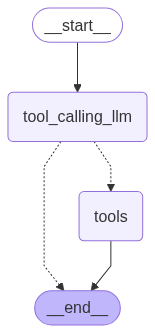

In [43]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# node defination
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", END)

# compile the graph
graph = builder.compile()

# give the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
# Call the chatbot (For tool calling)

response = graph.invoke({"messages" : "What is the recenet AI news?"})

In [38]:
response["messages"][-1].content

'{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.", "score": 0.7606688, "raw_content": null}, {"url": "https://www.instagram.com/reel/DLTfc5az1jx/", "title": "$500B AI Megaproject Begins After Trump\'s Inauguration Stargate ...", "content": "Photo by AI | Future Tech | Latest AI News | Daily AI Drops on June.", "score": 0.74697095, "raw_content": null}], "response_time": 3.17}'

In [39]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the recenet AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (vxdcry1g3)
 Call ID: vxdcry1g3
  Args:
    query: latest AI news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.", "score": 0.7606688, "raw_content": null}, {"url": "https://www.instagram.com/reel/DLTfc5az1jx/", "title": "$500B AI Megaproject Begins After Trump's Inauguration Stargate ...", "content": "Photo by AI | Future Tech | 

In [45]:
# Call the chatbot (For not calling tool)

response = graph.invoke({"messages" : "What is 2 multiplied by 3 and then multiplied by 7 ?"})
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3 and then multiplied by 7 ?
================================== Ai Message ==================================
Tool Calls:
  multiply (fcbrf4zfe)
 Call ID: fcbrf4zfe
  Args:
    first_number: 2
    second_number: 3
  multiply (yjk645evz)
 Call ID: yjk645evz
  Args:
    first_number: 6
    second_number: 7
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

42


### React Agent Architecture 

This architecture have 3 important parts:
1. Act
2. Obsserve
3. Reason

In case of multiple tools custom or pre-builded. When a input come (ACT) LLM will make a tool call then after that it will return back that response to LLM and (Observe)check weather this is all needed for the output if not then accordingly (Reason) either go to custom tool or pre-builded tool accordingly and again give back response to LLM and if it satisfied with total answer that ya this is the complete answer then it will return the output.

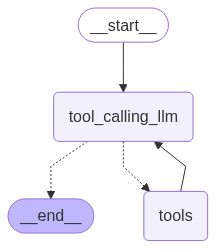

In [48]:
# Example

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# node defination
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END (Note: By default it goes to end if there is no tool calls.)
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

# compile the graph
graph = builder.compile()

# give the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
response = graph.invoke({"messages" : "Give me the latest ai news 10 points and then multiply 2 by 6"})
for message in response["messages"]:
    message.pretty_print()


================================ Human Message =================================

Give me the latest ai news 10 points and then multiply 2 by 6
================================== Ai Message ==================================
Tool Calls:
  tavily_search (t1ykh5jy1)
 Call ID: t1ykh5jy1
  Args:
    query: latest ai news
    time_range: day
    topic: news
  multiply (ef5rrt519)
 Call ID: ef5rrt519
  Args:
    first_number: 2
    second_number: 6
================================= Tool Message =================================
Name: tavily_search

{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://gizmodo.com/judge-finds-ai-companies-can-use-some-copyrighted-works-to-fuel-their-sludge-2000619677", "title": "Judge Rules AI Companies Can Use Some Copyrighted Works to Fuel Their Sludge - Gizmodo", "score": 0.6615081, "published_date": "Tue, 24 Jun 2025 20:10:53 GMT", "content": "Get the best tech, science, and culture news in you